#Explainable AI

## Worksheet 4: Trees-to-rules methods
---


---
### What are trees-to-rules methods?

InTrees is a model-specific XAI technique for explaining tree-ensemble models. For further information on the topic and definitions, we refer students to the lecture slides and recordings for the XAI technique (InTrees).

---

---

### Today's problem


The last notebook tutorial, we will look at methods which try to distill tree-based methods into sets of global rules that approximate how a given model behaves.

The most popular method that allows us to do this is called [inTrees](https://arxiv.org/abs/1408.5456). However, its original code implementation has been written in R and alternative approaches, which improve on the method, do exist. One of them is a Bayesian framework created by Hara and Hayashi in 2018 (you can find their paper [here](http://proceedings.mlr.press/v84/hara18a.html), and the project's GitHub repo [here](https://github.com/sato9hara/defragTrees)) that we will work with in this notebook.

This technique will be applied to a bank marketing dataset which you can find [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). We will use this information to create a classifier which will aim to predict whether a customer is going to subscribe to a new product introduced by a Portugese financial institution. As in the previous worksheets, we are facing a binary classification problem.

The notebook will use a LGBM model which is currently often a go-to approach in industry applications of Machine Learning.

---


## Example


### Importing libraries & data

Again, as in the previous worksheets, we will need to install a package which is not by default in Google colab. However, this package cannot be installed with pip, as it has not been shared on PyPI. The easiest way to use the package is to simply clone the git repository where it is now.

In [1]:
!git clone https://github.com/sato9hara/defragTrees.git

Cloning into 'defragTrees'...
remote: Enumerating objects: 2491, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2491 (delta 0), reused 0 (delta 0), pack-reused 2488
Receiving objects: 100% (2491/2491), 35.57 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (2158/2158), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from defragTrees.defragTrees import DefragModel
from hyperopt import hp, tpe
from hyperopt import space_eval
from hyperopt.fmin import fmin
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import random
random.seed(55)
np.random.seed(55)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/XAI-Worksheets/bank-additional-full.csv", sep=';')
df_col_used = df.columns.tolist()
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Data processing

Below, we will take the following steps, which you are used to by now.

*   Visually checking what we have in the DataFrame
*   Assessing and treating potential missingness
*   Creating new labels
*   Feature engineering new attributes
*   Dropping irrelevant columns





In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df_col_used

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

It may seem like we have no missing values here. However, if you check the previous call of `df.head()`, you can see that all missing values have been encoded as "unknown" across rows. Hence, they are interpreted as actual words/categories in the DataFrame. We should keep this in mind and reflect this in the table.

If we look at the dtypes inferred when importing the data, they are aligned with what the data descriptions said.

Let's focus on fixing the issue with encoding our missing values first, by transforming `unknown` values into `np.nan` values.

In [8]:
for col in df_col_used:
  df.loc[:, col] = [x if x != "unknown" else np.nan for x in df[col]]

Let's check the effects of this operation.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

It turns out that missing values should not be a major problem here. Only few columns are impacted by this data quality problem, and even in their case the impact is small (in the most affected "default" column, the rate of non-missingness is roughly 80%).

Let's clean up the DataFrame further. We start by droping all duplicated rows.

In [10]:
df = df.drop_duplicates()

Next we extract the labels.

In [11]:
labels = df["y"]

Now we can drop the label column. However, we will be dropping not only the label but also the "duration" column as the description of the dataset says "*this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*"

In [12]:
df = df.drop(columns = ["y", "duration"])

In the education column, we have categorical values, for which it makes sense to order them (i.e. from `illiterate` to `university degree`. We can do so by mapping the values to integers.

In [13]:
edu_dict = {"illiterate":1,
            "basic.4y":2,
            "basic.6y":3,
            "basic.9y":4,
            "high.school":5,
            "professional.course":6,
            "university.degree":7}

df["education"] = df["education"].map(edu_dict)

For "pdays" column, the value of 999 means that a customer has not been previously contacted. This encoding, however, indicates that 999 is a meaningful number, which is not true. We can transform 999s into missing values and add an indicator column to our dataset. There are no missing values as such in the column.

In [14]:
df["pdays_not_applicable"] = [1 if x == 999 else 0 for x in df["pdays"]]
df.loc[:, "pdays"] = [x if x != 999 else np.nan for x in df["pdays"]]

Our XAI package unfortunately requires that there are no missing values in our feature matrix. We will apply a simple imputations methods to eliminate this issue.

In [15]:
# Define which columns are purely categorical.
cats_features = df.select_dtypes('object').columns.tolist()
# Define which columns are numerical.
nums_features = [col for col in list(set(df.columns.tolist()) - set(cats_features))]
nums_features = sorted(nums_features)
# Specify the imputation methods.
imputer_num = SimpleImputer(missing_values = np.nan, strategy = 'median') # For numerical variables.
imputer_cat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') # For categorical variables.

Next, we can define a new feature matrix where the first columns are the categorical features and all numerical columns come after them.

In [16]:
column_assign = cats_features + nums_features
df = df[column_assign]

We can impute the missing values now so that the sampling methods can be used later.

In [17]:
df[nums_features] = imputer_num.fit_transform(df[nums_features])
df[cats_features] = imputer_cat.fit_transform(df[cats_features])

Futhermore, normally, for non-ordinal, categorical features we can adjust their data type in Pandas from "object" to "categorical" and pass them into LGBM.

A limitation of the defragTrees package, however, is that it cannot handle values which are not numerical. Hence, we will need to apply one-hot encoding here.

In [18]:
df_dummies = pd.get_dummies(df)

#### **Question 1:**
How does LGBM encode categorical features under the hood if they are passed into the model without one-hot encoding?

#### **Question 2:**
What is the difference between "object" and "category" dtypes in pandas?

Let's have a look at our new DataFrame.

In [19]:
df_dummies.head()

,age,campaign,cons.conf.idx,cons.price.idx,education,emp.var.rate,euribor3m,nr.employed,pdays,pdays_not_applicable,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56.0,1.0,-36.4,93.994,2.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,1,0,0,0,0,1,0
1,57.0,1.0,-36.4,93.994,5.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,1,0,0,0,0,1,0
2,37.0,1.0,-36.4,93.994,5.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,1,0,0,0,0,1,0
3,40.0,1.0,-36.4,93.994,3.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,1,0,0,0,0,1,0
4,56.0,1.0,-36.4,93.994,5.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,1,0,0,0,0,1,0


Next, we need to split the training, validation and test sets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies, labels, test_size=0.2, random_state=55)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=55)

In [21]:
X_train.head()

,age,campaign,cons.conf.idx,cons.price.idx,education,emp.var.rate,euribor3m,nr.employed,pdays,pdays_not_applicable,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
38041,31.0,4.0,-29.8,92.379,6.0,-3.4,0.773,5017.5,6.0,1.0,...,0,1,1,0,0,0,0,0,1,0
7163,31.0,2.0,-36.4,93.994,5.0,1.1,4.860,5191.0,6.0,1.0,...,0,0,0,0,1,0,0,0,1,0
514,59.0,1.0,-36.4,93.994,5.0,1.1,4.857,5191.0,6.0,1.0,...,0,0,0,0,0,1,0,0,1,0
10712,22.0,2.0,-41.8,94.465,2.0,1.4,4.961,5228.1,6.0,1.0,...,0,0,0,0,0,1,0,0,1,0
18525,43.0,8.0,-42.7,93.918,2.0,1.4,4.968,5228.1,6.0,1.0,...,0,0,0,0,1,0,0,0,1,0


### Modelling

We will train an LGBM model below with arbitrarily picked hyperparameters. This will be followed by optimising the hyperparameters to improve the performance and, hence, figure out the best rules for our problem with defragTrees.

In [24]:
# params dictionary holds arbitrary hyperparameter values.
params = {
    'max_depth': 6,
    'min_child_weight': 0,
    'learning_rate': 0.5,  # Ensure this is a float, not string
    'colsample_bytree': 0.75,  # Ensure this is a float, not string
    'subsample': 1,
    'reg_lambda': 1,
    'n_estimators': 150,
    'objective': 'binary',
    'random_state': 55,
    'verbose': -1
}

# Create LGBMClassifier instance
lgb_model = lgb.LGBMClassifier(**params)

# Fitting the model on the training set and controlling for overfitting with early stopping
lgb_fitted = lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(500)]  # Using early_stopping as a callback
)


Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.272925


Now, let's assess the model's performance.

The simple function below will be used to the test data to check how predictive the classifier is.

Confusion Matrix:


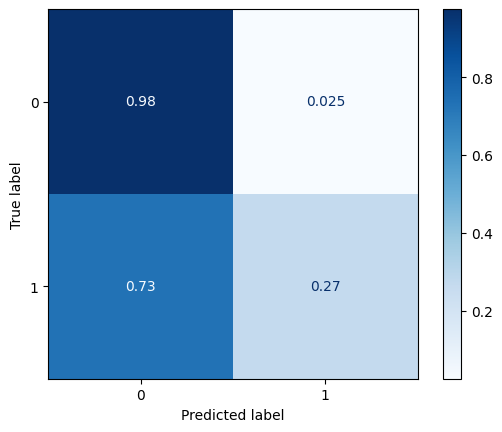

Classification Report:
              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7287
         yes       0.58      0.27      0.37       949

    accuracy                           0.89      8236
   macro avg       0.75      0.62      0.65      8236
weighted avg       0.87      0.89      0.88      8236



Done


In [25]:
def model_assessment(model, X, y):
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, model.predict(X), normalize='true'))
    disp.plot(cmap=plt.cm.Blues)
    disp.title = "Normalized Confusion Matrix"
    plt.show()

    #produce a classification report
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')
    print("Done")

model_assessment(lgb_fitted, X_test, y_test)

The results above suggest that we may be perhaps facing a class imbalance problem. Let's see the counts of values for the two classes across the sets.

#### **Question 3:**
Which is the most important metric in the table above that we should aim to maximise? Explain your point of view.

Let's print the results.

In [26]:
print("Training set:")
print(y_train.value_counts())
print("---")
print("Validation set:")
print(y_val.value_counts())
print("---")
print("Test set:")
print(y_test.value_counts())

Training set:
no     23398
yes     2954
Name: y, dtype: int64
---
Validation set:
no     5852
yes     736
Name: y, dtype: int64
---
Test set:
no     7287
yes     949
Name: y, dtype: int64


This clearly indicates that the model learns on imbalanced data (roughly 10 instances of class 0 to class 1) and cannot pick up what atttributes characterise the minority class (class 1 here).

We now define the sampling operations and chain them.

In [27]:
smote = SMOTE(sampling_strategy = 0.2, random_state = 55)
undersample = RandomUnderSampler(sampling_strategy = 0.7, random_state = 55)

# The process:
# - Create new samples of the minority class to bring the balance to 2:10 (minority to majority class).
# - Then, remove some samples of the majority class to bring the balance to 7:10.
pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

# Apply over/undersampling.
X_rebalanced, y_rebalanced = pipeline.fit_resample(X_train, y_train)

Let's fit and assess the new model.

Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.365552
Confusion Matrix:


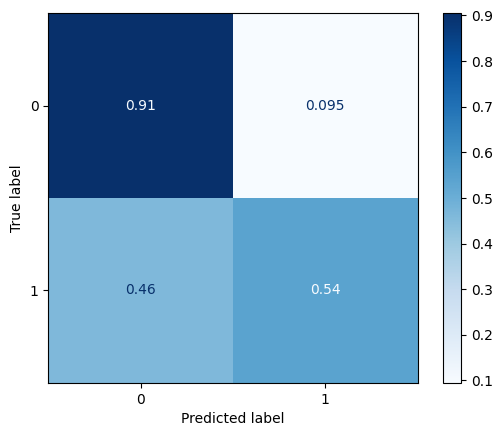

Classification Report:
              precision    recall  f1-score   support

          no       0.94      0.91      0.92      7287
         yes       0.42      0.54      0.47       949

    accuracy                           0.86      8236
   macro avg       0.68      0.72      0.70      8236
weighted avg       0.88      0.86      0.87      8236



Done


In [29]:
# Assuming lgb_model is already created with the necessary parameters including 'verbose'
lgb_fitted = lgb_model.fit(
    X_rebalanced, y_rebalanced,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(500)]  # Using early_stopping as a callback
)

# Assuming model_assessment is a function you have defined to assess your model
model_assessment(lgb_fitted, X_test, y_test)


Another interesting metric to explore is Matthews correlation coefficient (MCC).
The coefficient is a balanced measure for binary classification that is able to handle class imbalance, where a MCC of 1 represents perfect prediction, 0 would indicate the model is akin to random, and -1 is a complete inverse of the true classifications. You can find more information [here](https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html).


In [30]:
y_pred = lgb_fitted.predict(X_val)
score = matthews_corrcoef(y_val, y_pred)
print("MCC of:")
print(score)

MCC of:
0.43751310372582725


#### **Question 4:**
Why does it make sense to check the MCC for this model? Why do some argue that it is a better measure than F-1 score or accuracy?

We are now doing better than before in terms of distinguishing between the two classes. The model is not placing almost all observations in the "no" bucket. In addition, the MCC, F-1 and accuracy outputs indicate good overall performance.  

Unfortunately, the predictions for the "yes" samples are still quite poor, even though the recall/precision balance is less extreme.

### Establishing rules

Once the model has been trained and optimised, we can try to distill it.

The first thing that we can do to make the algorithm work faster is to figure out which features have the most predictive power.




One way to do so, is to extract feature importances according to the number of splits (numbers of times the feature is used in a model).

Axes(0.125,0.11;0.775x0.77)


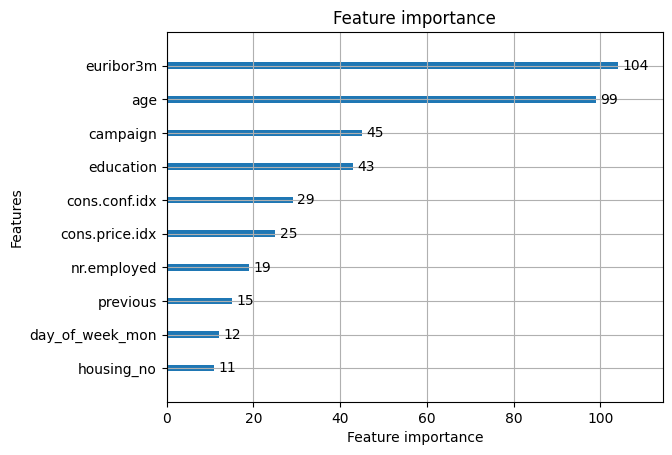

In [31]:
# Get the underlying booster.
booster = lgb_fitted.booster_

# Produce visualisations.
print(lgb.plot_importance(booster, max_num_features = 10, importance_type='split'))

Let's create a list of the most important features

In [32]:
#Version change, feature importance lists features by name RANDMOMSTATE =55
best_cols = ['age','euribor3m', 'campaign', 'education','cons.conf.idx', 'cons.price.idx','poutcome_failure','day_of_week_thu', 'day_of_week_mon', 'day_of_week_fri']

#### **Question 5:**
What are the other measures of feature importance that could be used here? Use one and check if your method would point to the same columns in the dataset as the 10 most important ones.

We can now retrain our model only using the columns above, save it and extract rules based on the features in best_cols. We start by extracting the relevant subset of the data.

In [33]:
X_rebalanced_simple = X_rebalanced[best_cols]
X_val_simple = X_val[best_cols]
X_test_simple = X_test[best_cols]

Before fitting the final model, let us map the classes to numbers as needed by the package.

In [34]:
label_dict = {"yes":1, "no":0}
y_rebalanced = pd.Series(y_rebalanced).map(label_dict)
y_val = y_val.map(label_dict)
y_test = y_test.map(label_dict)

Now we can fit the model.

In [36]:
lgb_fitted = lgb_model.fit(
    X_rebalanced_simple, y_rebalanced,
    eval_set=[(X_val_simple, y_val)],
    callbacks=[lgb.early_stopping(500)]  # Using early_stopping as a callback
)


Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.377616


We can save our simplified LightGBM model details in a .txt file.

In [37]:
lgb_fitted.booster_.save_model('lgbmodel.txt')

Let's check the performance of our simple model too.

Confusion Matrix:


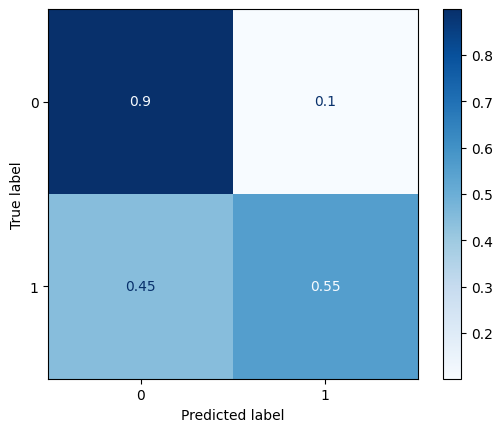

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7287
           1       0.42      0.55      0.48       949

    accuracy                           0.86      8236
   macro avg       0.68      0.73      0.70      8236
weighted avg       0.88      0.86      0.87      8236



Done


In [38]:
model_assessment(lgb_fitted, X_test_simple, y_test)

Having determined our simplified LGBM model performs as well as before, let us now derive rules using DefragTrees.

In [39]:
# Set the maximum number of rules, Kmax.
# We can set it to 10.
Kmax = 10

# Parse the model saved in the .txt file.
splitter = DefragModel.parseLGBtrees('./lgbmodel.txt')

# Initialise the algorithm and specify the values of hyperparameters that
# will govern the process of extracting the global rules.
mdl = DefragModel(modeltype='classification', maxitr=100, qitr=0, tol=1e-6, restart=20, verbose=0, L=5)

# Fit the algorithm to the training data and evaluate it on the test data.
mdl.fit(X_rebalanced_simple.to_numpy(), y_rebalanced.to_numpy(), splitter, Kmax, fittype='FAB', featurename=best_cols)

score, cover, coll = mdl.evaluate(X_test_simple.to_numpy(), y_test.to_numpy())
print()
print('<< defragTrees >>')
print('----- Evaluated Results -----')
print('Test Error = %f' % (score,))
print('Test Coverage = %f' % (cover,))
print('Overlap = %f' % (coll,))
print()
print('----- Found Rules -----')
print(mdl)

[Seed   0] TrainingError = 0.30, K = 10
[Seed   1] TrainingError = 0.29, K = 10
[Seed   2] TrainingError = 0.35, K = 10
[Seed   3] TrainingError = 0.33, K = 9
[Seed   4] TrainingError = 0.30, K = 8
[Seed   5] TrainingError = 0.28, K = 7
[Seed   6] TrainingError = 0.32, K = 9
[Seed   7] TrainingError = 0.27, K = 8
[Seed   8] TrainingError = 0.39, K = 8
[Seed   9] TrainingError = 0.27, K = 8
[Seed  10] TrainingError = 0.28, K = 9
[Seed  11] TrainingError = 0.38, K = 9
[Seed  12] TrainingError = 0.49, K = 9
[Seed  13] TrainingError = 0.27, K = 9
[Seed  14] TrainingError = 0.27, K = 8
[Seed  15] TrainingError = 0.27, K = 9
[Seed  16] TrainingError = 0.35, K = 7
[Seed  17] TrainingError = 0.27, K = 8
[Seed  18] TrainingError = 0.28, K = 9
[Seed  19] TrainingError = 0.26, K = 7
Optimal Model >> Seed  19, TrainingError = 0.26, K = 7

<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.170471
Test Coverage = 1.000000
Overlap = 1.000000

----- Found Rules -----
[Rule  1]
y = 0 when
	

/content/defragTrees/defragTrees.py:335: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rule = np.array(rule)[idx].tolist()


*Note: The InTrees algorithm may produce different rules on your system, and so it is possible that the following interperation of the output does not match what you receive.*

Amazing! Our algorithm has found 8 rules which result in a test error of 18.4% (or 81.6% accuracy) when applied to the test set (the coverage is 100%).


#### **Question 6:**
Are any of these rules redundant? How can we combine them into a shorter set?

We can further simplify the output. Let's re-run the code but set the maximum number of rules to 3.

In [40]:
Kmax = 3
mdl.fit(X_rebalanced_simple.to_numpy(), y_rebalanced.to_numpy(), splitter, Kmax, fittype='FAB', featurename=best_cols)

score, cover, coll = mdl.evaluate(X_test_simple.to_numpy(), y_test.to_numpy())
print()
print('<< defragTrees >>')
print('----- Evaluated Results -----')
print('Test Error = %f' % (score,))
print('Test Coverage = %f' % (cover,))
print('Overlap = %f' % (coll,))
print()
print('----- Found Rules -----')
print(mdl)

[Seed   0] TrainingError = 0.28, K = 3
[Seed   1] TrainingError = 0.31, K = 3
[Seed   2] TrainingError = 0.35, K = 3
[Seed   3] TrainingError = 0.32, K = 3
[Seed   4] TrainingError = 0.35, K = 3
[Seed   5] TrainingError = 0.32, K = 3
[Seed   6] TrainingError = 0.32, K = 3
[Seed   7] TrainingError = 0.27, K = 3
[Seed   8] TrainingError = 0.55, K = 3
[Seed   9] TrainingError = 0.28, K = 3
[Seed  10] TrainingError = 0.28, K = 3
[Seed  11] TrainingError = 0.30, K = 3
[Seed  12] TrainingError = 0.36, K = 3
[Seed  13] TrainingError = 0.27, K = 3
[Seed  14] TrainingError = 0.28, K = 3
[Seed  15] TrainingError = 0.27, K = 3
[Seed  16] TrainingError = 0.35, K = 3
[Seed  17] TrainingError = 0.34, K = 3
[Seed  18] TrainingError = 0.28, K = 3
[Seed  19] TrainingError = 0.28, K = 3
Optimal Model >> Seed  15, TrainingError = 0.27, K = 3

<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.125182
Test Coverage = 1.000000
Overlap = 0.601384

----- Found Rules -----
[Rule  1]
y = 0 when
	 eu

*Note: Again, the interpretation of the rules may be different than your output.*

The test error is 16.4% and the coverage is the same as before but we have only 3 rules to consider. Those are:

*   If age > 29.019046 and euribor3m > 1.280790, class 0 (no)
*   If age <= 58.525991 and euribor3m > 1.280790, class 0 (no)
*   If euribor3m <= 4.192393, class 1 (yes)
*   In any other case, it will be class 0 (no)

In other words, we only need to consider 2 features to craft a rule-based model whose overall accuracy would be better than 83%:

*   euribor3m - Euribor 3 month rate (Eurozone interest rate benchmark)
*   age - client age (numeric)

We can collapse those three rules and create a system that is even simpler if we look closely at the conditions. It would be:

"If the eurozone interest rate is less than  or equal to 4.19%, then this customer will be predicted as class 1."




We can further double-check the accuracy of such rule.

In [41]:
#Based on new, simpler outputs
rule_outcome = [1 if val1 <= 4.192393 else 0 for val1 in  X_test_simple["euribor3m"]]
print(classification_report(y_test, rule_outcome))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76      7287
           1       0.21      0.74      0.32       949

    accuracy                           0.64      8236
   macro avg       0.58      0.69      0.54      8236
weighted avg       0.86      0.64      0.71      8236



The results above show that one simple rule can be as good as a LGBM model with over/undersampling applied to it!

#### **Question 7:**
Is a model that can be replaced by a rule looking at the eurozone interest rate and consumer confidence index a sensible construct? What factors could be driving this relationship between the feature and the outcome label?



---

## Assignment 4


1.   Given that the observations are ordered by the time dimension (the earliest samples are the first ones in the dataset; see the description of the dataset on the UCI's website) and we want to predict the outcomes of future engagements, what would be the best training-validation-test splitting strategy? Split the observations in a way that you would consider the most appropriate.
2.   What are the problems with imputing means and medians? Are there any other imputation methods which we could consider and would result in better
quality imputed data? What packages in Python can be used to apply them?
3.   Name other methods of deadling with imbalanced datasets apart from under/oversampling.
4.   Instead of a LGBM model, train and assess an XGBoost model on the provided dataset. Which hyperparameters of XGBoost could we tweak to improve its performance on this imbalanced dataset?
5.   Check how the imbalance changes with time - for example, plot how many "no" observations we have per one "yes" observation among the first 10000 samples, the next 10000 etc. (this way, you will get 5 ratios (obs. 1-10000, 10001-20000, 20001-30000, 30001-40000, 40001-41188)). Can you see any trends? If yes, what is the implication of this for the model building?  
6.   Distill the model you created in 4. into a set of rules using defragTrees. What is the test error of this system? Can you simplify it further? Is is different from what has been generated under a LGBM model?

